# Energy and time optimizations for double-pendulum reaching model. 

In the following code we create a doublePendulum model and perform optimizations to find the trajectories and movement times for reaches of different distances, and different valuations of time.

if you set 'theGeneratePlots=1', you will get 6 plots per optimization.



******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     5628
Number of nonzeros in inequality constraint Jacobian.:     2426
Number of nonzeros in Lagrangian Hessian.............:     2518

Total number of variables............................:     1819
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equa

RuntimeError: Error in Opti::set_value [OptiNode] at .../casadi/core/optistack.cpp:143:
.../casadi/core/optistack_internal.cpp:1202: Assertion "v==e[i]" failed:
In initial/value assignment: inconsistent numerical values. At nonzero 0, lhs has 0.129624, while rhs has 0.456684.

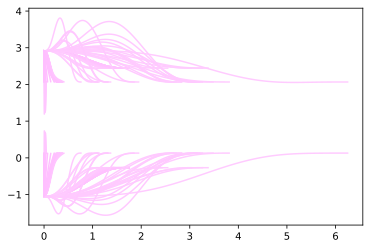

In [1]:
#%% Loop across distances and valuations to generate double-pendulum distance/time predictions. 
import DoublePendulumClass as dp
import numpy as np
import matplotlib.pyplot as plt
%config InlineBackend.figure_formats = ['svg']
import sys
sys.path.insert(0,'parameterFiles')

# model that has equations to compute endpoint jacobians, equations of motion, and energy. 
sim = dp.kinarmModel()

x = 0.0
ys = 0.2
xystart = np.array([x,ys])

#loopValuation = [5, 3, 1, .75, .5, .25, .05, .01]
#loopdist = np.array([.0025, .005, .01, .02, .04, .06, .1, .2, .3, .5])
loopValuation = [15,5, 3, 1, .75, .5, .25, .05, .01]
loopdist = np.array([.0025, .005, .01, .02, .04, .06, .1, .2, .3, .5])
loopValuation = [1]
loopdist = np.array([.1, .2, .3, .5])

distcolors = ['#f7fcf0','#e0f3db','#ccebc5','#a8ddb5','#7bccc4','#4eb3d3','#2b8cbe','#0868ac','#084081']

M = len(loopdist)
N = len(loopValuation)
duration = np.zeros([M, N])
J = np.zeros([M, N])
costFR = np.zeros([M, N])
costWork = np.zeros([M, N])
costTime = np.zeros([M, N])
peakhandspeed = np.zeros([M, N])

# get all trajectories
trajRows = list()
trajCols = list() 

# get all optimization results
optiRows = list()
optiCols = list()

mDist = 0
nVal = 0

prevSol = []
dGuess = 1.0
prevOpti = sim.movementTimeOptSetup(xystart,xystart + np.array([x,.1]), \
      theTimeValuation=1.0,theN = 100, theGeneratePlots=0, LINEAR_GUESS= \
      False, theDurationGuess = 1.1)
for i in loopdist:
  for j in loopValuation:
    trajResult, optiReturn = sim.updateGuessAndSolve(prevOpti,xystart,\
      xystart+np.array([x,i]), durationInitial = dGuess,\
      theGeneratePlots=0)
    
    #unpack the results
    duration[mDist,nVal] = trajResult.duration
    J[mDist,nVal] = trajResult.costJ
    costFR[mDist,nVal] = trajResult.costFR
    costWork[mDist,nVal] = trajResult.costWork
    costTime[mDist,nVal] = trajResult.costTime
    peakhandspeed[mDist,nVal] = trajResult.costTime
    nVal += 1
    trajCols.append(trajResult)
    optiCols.append(optiReturn)
    if trajResult.solved & nVal<len(loopValuation):
      prevOpti = optiReturn
      dGuess = trajResult.duration
  nVal = 0
  mDist += 1
  trajRows.append(trajCols)
  optiRows.append(optiCols)
  trajCols = []
# %%


In [5]:
b = trajRows[1][0]
b.solved

False

In [2]:
solution

OptiSol(Opti {
  instance #89
  #variables: 5 (nx = 1819)
  #parameters: 0 (np = 0)
  #constraints: 244 (ng = 2444)
  CasADi solver allocated.
  CasADi solver was called: Solve_Succeeded
})

(0.0, 7.0)

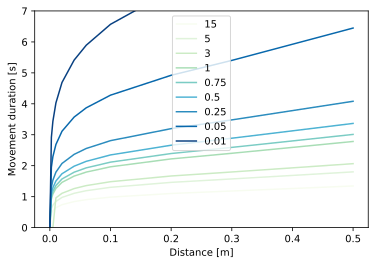

In [3]:
#%% Figure 1: distance / time 

f,ax = plt.subplots()
for v in range(0,len(loopValuation)):
#v = 0
  xtemp = loopdist.copy()
  y = duration.copy()
  y = y[:,v]
  ytemp = np.concatenate(([0],y))

  xtemp = np.concatenate(([0],xtemp))
  plt.plot(xtemp,ytemp,label=loopValuation[v],color = distcolors[v])
plt.legend()
# %%
plt.xlabel("Distance [m]")
plt.ylabel("Movement duration [s]")
ax.set_ylim(0,7)


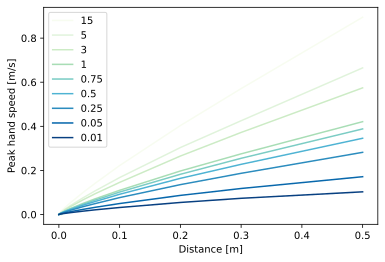

In [4]:
#%% Figure 2: distance peak speed / distance
f,ax = plt.subplots()
for v in range(0,len(loopValuation)):
#v = 0
  xtemp = loopdist.copy()
  y = peakhandspeed.copy()
  y = y[:,v]
  ytemp = np.concatenate(([0],y))

  xtemp = np.concatenate(([0],xtemp))
  plt.plot(xtemp,ytemp, label=loopValuation[v],color = distcolors[v])
  plt.xlabel("Distance [m]")
  plt.ylabel("Peak hand speed [m/s]")
  plt.legend()
# %%

Text(0.5, 0, 'Time [s]')

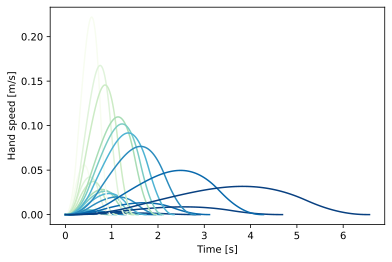

In [5]:
#%% Figure 3: 3 valuations, hand speed vs time
def plotBells(theList):
  for i in range(0,len(theList)):
    tempStruct = theList[i]  
    plt.plot(tempStruct.time,tempStruct.handspeed,distcolors[i])

f,ax = plt.subplots()
plotBells(trajRows[0])
plotBells(trajRows[3])
plotBells(trajRows[-4])
plt.ylabel("Hand speed [m/s]")
plt.xlabel("Time [s]")


In [6]:
# #%% Figure 4: COST plot. 
# f,ax = plt.subplots()
# v = np.where(loopValuation ==1)

# xtemp = loopdist.copy()
# xtemp = np.concatenate(([0],xtemp))

# y = workCost.copy()
# y = y[:,v]
# ytemp = np.concatenate(([0],y))
# y2 = frCost.copy()
# y2 = y2[:,v]
# y2temp = np.concatenate([0],y2)

# plt.plot(xtemp,ytemp, label=loopValuation[v],color = distcolors[v])
# plt.plot(xtemp,ytemp, label=loopValuation[v],color = distcolors[v])
# d
# plt.xlabel("Distance [m]")
# plt.ylabel("Peak hand speed [m/s]")
# plt.legend()
# # %%
